In [17]:
import sqlite3
import zipfile
import os
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pymc

In [18]:
os.getcwd()

'/Users/fhall/Desktop/Programming/Python/PowerSupply/energy_dashboard'

- [x] 1: Load the data into the analytics tool (or tools) of your choice
- [x] 2: Present your proposed data model for getting the data into a state for reporting and long-term data warehousing
 - Please include some SQL statements that you would write to build this model and do the necessary transformations to prepare the data for reports you would want to build, if these CSVs were tables in a data warehouse.
 - Also include any data validation or cleaning steps that you would do at this part of the pipeline (or communicate to a data engineering team to implement).
- [ ] 3: What process would you use to design a dashboard that would enable users to interpret and gain insights from these datasets?
 - You can either create a dashboard to demonstrate this, or just write up a plan for how you would do so.
- [ ] 4: If you have access to your ideal tool/process (presented in step 3) for building some visualizations, please utilize those. If not, use whatever graphing tools you have access to in order to visualize relationships between the following data:
 - Note that total energy cost is the product of price and demand
 - Energy price vs Temperature
 - Energy demand vs Temperature
 - Energy price vs. demand
 - Develop one or more figures that help to explain how the total wholesale cost of energy changes with season, day of week, and temperature. 
- [ ] 5: Choose one of the plots that you developed above and explain/show how you would display/design the plot differently for two different audiences:
 - A utility program manager who had deep expertise with this type of data
 - A neighborhood/town board member who is interested in clean energy but doesn’t have any specific energy expertise.
- [ ] 6: From the figures you’ve created, what other meaningful patterns do you see in the data?

In [3]:
def clean_file(df, filename):
    
    if 'weather' in filename:
        df.columns = ['datetime','4008','4003']
        df = pd.melt(raw, id_vars=['datetime'], var_name='Location', value_name='t_f')
    
    else:
        df = df.rename(columns={'BeginDate': 'datetime'})
        df['Location'] = df.Location.apply(lambda x: x[12:16])        
    
    df = df.drop_duplicates()
    
    df['datetime'] = pd.to_datetime(df.datetime, utc=True)
    df['datetime_hourly'] = df.datetime.dt.floor("h")
    
    df['datetime'] = df.datetime.dt.tz_convert('America/New_York') # re-assign EST
    df['datetime_hourly'] = df.datetime_hourly.dt.tz_convert('America/New_York')
    
    df['datetime'] = df.datetime.astype('str') # convert to str for sql
    df['datetime_hourly'] = df.datetime_hourly.astype('str')
    
    df['datetime_hourly'] = df.datetime_hourly.str.slice(stop=-6)
    return df

In [4]:
zip_file_path = 'data/Data_Analyst_Interview_Data.zip'

# Extract the database file from the ZIP archive
# subfolder = 'Data_Analyst_Interview_Data/'

# Connect to the SQLite database
conn = sqlite3.connect('EH_Example.db')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for f in zip_ref.infolist():
        if (~f.filename.startswith('__MAC') & f.filename.endswith('csv')):
            csv_file_name = f.filename[30:-4].replace('-', '_')
            print(csv_file_name)
            
            raw = pd.read_csv('data/'+f.filename) # read file
            df = clean_file(raw,csv_file_name)

            # Write the DataFrame to the SQLite database
            df.to_sql(csv_file_name.split('.')[0], conn, if_exists='replace', index=False)

# Commit the changes to the database
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()

iso_ne_hourly_demand_2021
weather_data
iso_ne_fivemin_lmp_2021


### BUILD HOURLY + LOCATION TABLE

In [5]:
start_date = dt(2021, 1, 1)
end_date = dt(2021, 12, 31, 23)  # Include the last hour of the year
hourly_index = pd.date_range(start=start_date, end=end_date, freq='H')
hourly_data_vt = pd.DataFrame({'datetime_hourly': hourly_index, 'Location': ['4003' for _ in range(len(hourly_index))]})
hourly_data_ma = pd.DataFrame({'datetime_hourly': hourly_index, 'Location': ['4008' for _ in range(len(hourly_index))]})
hourly_data_df = pd.concat([hourly_data_vt,hourly_data_ma])

In [6]:
# Step 2: Create or connect to a SQLite3 database
conn = sqlite3.connect('EH_Example.db')

# Step 3: Create a table in the database
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS HourlyData (
        id INTEGER PRIMARY KEY,
        datetime_hourly DATETIME,
        Location FLOAT
    )
''')

# Step 4: Insert the generated hourly data into the table
hourly_data_df.to_sql('HourlyData', conn, index=False, if_exists='replace')

# Commit the changes and close the connection
conn.commit()
conn.close()

In [5]:
# CREATE ONE HOURLY TABLE
conn = sqlite3.connect('EH_Example.db')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Create a composite index on column1 and column2
cursor.execute('CREATE INDEX IF NOT EXISTS idx_column1_column2 ON iso_ne_hourly_demand_2021(datetime_hourly, Location)')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_column1_column2 ON weather_data(datetime_hourly, Location)')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_column1_column2 ON iso_ne_fivemin_lmp_2021(datetime_hourly, Location)')
cursor.execute('CREATE INDEX IF NOT EXISTS idx_column1_column2 ON HourlyData(datetime_hourly, Location)')

## ACCESS DATA

In [ ]:
# CREATE ONE HOURLY TABLE
conn = sqlite3.connect('EH_Example.db')

# Create a cursor object to interact with the database
cursor = conn.cursor()

x = pd.read_sql_query('''SELECT
                    HourlyData.datetime_hourly,
                    HourlyData.Location as Location,
                    
                    AVG(t_f) as 't_f',
                    AVG(LmpTotal) as 'lmp',
                    AVG(Load) as 'load'
                    
                    FROM HourlyData 
                    LEFT JOIN iso_ne_hourly_demand_2021
                    ON HourlyData.datetime_hourly = iso_ne_hourly_demand_2021.datetime_hourly
                    AND HourlyData.Location = iso_ne_hourly_demand_2021.Location
                    
                    LEFT JOIN iso_ne_fivemin_lmp_2021
                    ON HourlyData.datetime_hourly = iso_ne_fivemin_lmp_2021.datetime_hourly
                    AND HourlyData.Location = iso_ne_fivemin_lmp_2021.Location
                    
                    LEFT JOIN weather_data
                    ON HourlyData.datetime_hourly = weather_data.datetime_hourly
                    AND HourlyData.Location = weather_data.Location
                    
                    group by HourlyData.datetime_hourly, HourlyData.Location
                    ''', conn)

cursor.close()
conn.close()

In [3]:
# CREATE ONE HOURLY TABLE
conn = sqlite3.connect('EH_Example.db')

# Create a cursor object to interact with the database
cursor = conn.cursor()

x = pd.read_sql_query('''SELECT
                    datetime_hourly,Location
                    FROM HourlyData
                    ''', conn)

e = pd.read_sql_query('''SELECT
                    Location,
                    datetime_hourly,
                    AVG(Load) as 'energy'
                    FROM iso_ne_hourly_demand_2021
                    GROUP BY Location, datetime_hourly
                    ''', conn)

l = pd.read_sql_query('''SELECT
                    Location,
                    datetime_hourly,
                    AVG(LmpTotal) as 'lmp',
                    AVG(LossComponent) as 'loss',
                    AVG(CongestionComponent) as 'congestion',
                    AVG(EnergyComponent) as 'energyCost'
                    FROM iso_ne_fivemin_lmp_2021
                    GROUP BY LOCATION, datetime_hourly
                    ''', conn)

w = pd.read_sql_query('''SELECT
                    Location,
                    datetime_hourly,
                    t_f
                    FROM weather_data
                    GROUP BY LOCATION, datetime_hourly
                    ''', conn)




cursor.close()
conn.close()

df_final = x.merge(e,how='left').merge(l,how='left').merge(w,how='left')

df_final.datetime_hourly = pd.to_datetime(df_final.datetime_hourly,utc=True)
df_final['day'] = df_final.datetime_hourly.dt.date
df_final['month'] = df_final.datetime_hourly.dt.month
df_final['hour'] = df_final.datetime_hourly.dt.hour + 1
df_final['season'] = df_final.month.apply(lambda x: 'summer' if x in (6,7,8,9) else 'winter')
df_final['Location'] = df_final.Location.apply(lambda x: 'VT' if x == '4003' else 'NEMA')

vt_max = max(df_final[(df_final.energy.notnull()) & (df_final.Location == 'VT')].energy)
nema_max = max(df_final[(df_final.energy.notnull()) & (df_final.Location == 'NEMA')].energy)

vt_total_energy = sum(df_final[(df_final.energy.notnull()) & (df_final.Location == 'VT')].energy)
nema_total_energy = sum(df_final[(df_final.energy.notnull()) & (df_final.Location == 'NEMA')].energy)


df_final['energy_normalized'] = df_final.apply(lambda row: row['energy']/nema_max if row['Location'] == 'NEMA' else row['energy']/vt_max, axis=1)
df_final['total_lmp'] = (df_final.energy * df_final.lmp)
df_final['total_energyCost'] = (df_final.energy * df_final.energyCost)
df_final['total_loss'] = (df_final.energy * df_final.loss)
df_final['total_congestion'] = (df_final.energy * df_final.congestion)

df_final['weighted_lmp'] = df_final.apply(lambda row: row['total_lmp']/nema_total_energy if row['Location'] == 'NEMA' else row['total_lmp']/vt_total_energy, axis=1)
df_final['weighted_energyCost'] = df_final.apply(lambda row: row['total_energyCost']/nema_total_energy if row['Location'] == 'NEMA' else row['total_energyCost']/vt_total_energy, axis=1)
df_final['weighted_loss'] = df_final.apply(lambda row: row['total_loss']/nema_total_energy if row['Location'] == 'NEMA' else row['total_loss']/vt_total_energy, axis=1)
df_final['weighted_congestion'] = df_final.apply(lambda row: row['total_congestion']/nema_total_energy if row['Location'] == 'NEMA' else row['total_congestion']/vt_total_energy, axis=1)



In [5]:
vt_total_lmp = sum(df_final[(df_final.total_lmp.notnull()) & (df_final.Location == 'VT')].total_lmp)
nema_total_lmp = sum(df_final[(df_final.total_lmp.notnull()) & (df_final.Location == 'NEMA')].total_lmp)


In [8]:
df_final['lmp_cost_pct'] = df_final.apply(lambda row: row['total_lmp']/nema_total_lmp if row['Location'] == 'NEMA' else row['total_lmp']/vt_total_lmp, axis=1)


In [14]:
sum(df_final[df_final['lmp_cost_pct'].notnull()].lmp_cost_pct)

2.000000000000003

In [4]:
df_final.to_csv('data/final_dashboard_df.csv')

In [ ]:
df_final.head(2)

#### CHECK NAs

In [322]:
df_final.isnull().sum()

datetime_hourly        0
Location               0
energy                23
lmp                    6
loss                   6
congestion             6
energyCost             6
t_f                  382
day                    0
month                  0
hour                   0
season                 0
energy_normalized     23
weighted_lmp          27
dtype: int64

## READ DATA FROM SQL

In [39]:
# conn = sqlite3.connect('EH_Example.db')
# cursor = conn.cursor()

# load = pd.read_sql_query("select * from iso_ne_hourly_demand_2021", conn)
# weather = pd.read_sql_query("select * from weather_data", conn)
# lmp = pd.read_sql_query("select * from iso_ne_fivemin_lmp_2021", conn)

 - Energy price vs Temperature
 - Energy demand vs Temperature
 - Energy price vs. demand
 - Develop one or more figures that help to explain how the total wholesale cost of energy changes with season, day of week, and temperature. 

In [65]:
df_final.head(4)

,datetime_hourly,Location,energy,lmp,t_f,day,month,hour,season
0,2021-01-01 00:00:00+00:00,VT,610.159,26.071667,25.1,2021-01-01,1,1,winter
1,2021-01-01 01:00:00+00:00,VT,588.621,43.751667,26.0,2021-01-01,1,2,winter
2,2021-01-01 02:00:00+00:00,VT,573.332,24.340000,26.1,2021-01-01,1,3,winter
3,2021-01-01 03:00:00+00:00,VT,567.419,24.612500,27.1,2021-01-01,1,4,winter


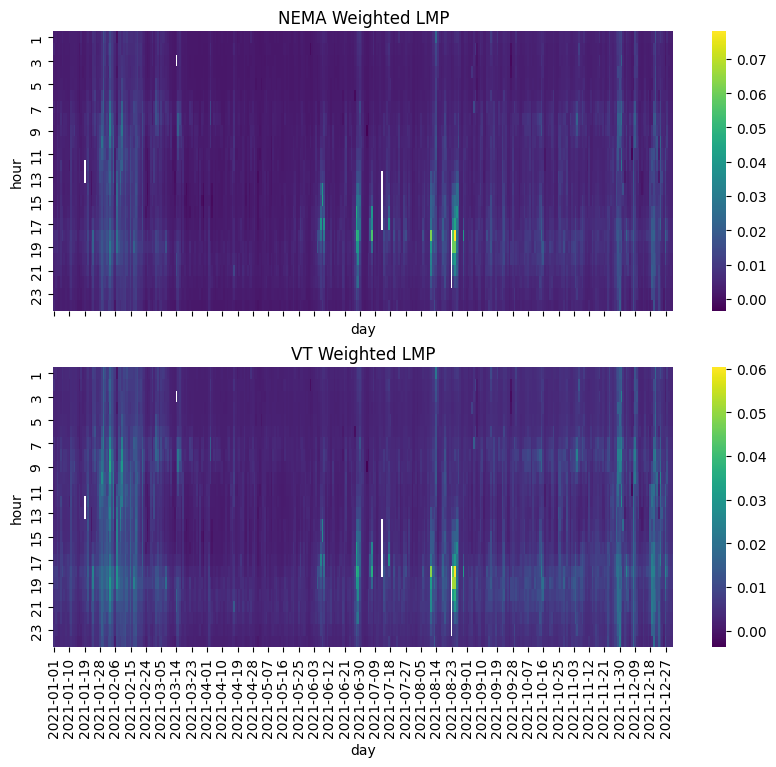

In [386]:
vt_load = df_final[df_final.Location == 'VT'][['day','hour','weighted_lmp']]
vt_heatmap = vt_load.pivot_table(index='hour',columns='day',values='weighted_lmp',aggfunc='mean')

nema_load = df_final[df_final.Location == 'NEMA'][['day','hour','weighted_lmp']]
nema_heatmap = nema_load.pivot_table(index='hour',columns='day',values='weighted_lmp',aggfunc='mean')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),sharex=True)
sns.heatmap(nema_heatmap, cmap='viridis', cbar=True,ax=ax1)
ax1.set_title('NEMA Weighted LMP')
sns.heatmap(vt_heatmap, cmap='viridis', cbar=True,ax=ax2)
ax2.set_title('VT Weighted LMP');

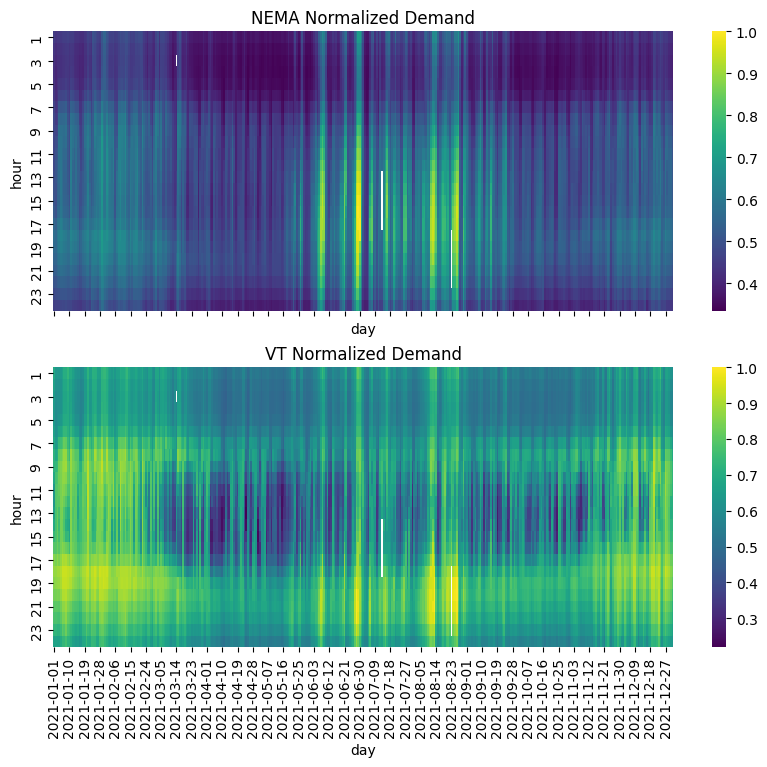

In [383]:
vt_load = df_final[df_final.Location == 'VT'][['day','hour','energy_normalized']]
vt_heatmap = vt_load.pivot_table(index='hour',columns='day',values='energy_normalized',aggfunc='mean')

nema_load = df_final[df_final.Location == 'NEMA'][['day','hour','energy_normalized']]
nema_heatmap = nema_load.pivot_table(index='hour',columns='day',values='energy_normalized',aggfunc='mean')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),sharex=True)
sns.heatmap(nema_heatmap, cmap='viridis', cbar=True,ax=ax1)
ax1.set_title('NEMA Normalized Demand')
sns.heatmap(vt_heatmap, cmap='viridis', cbar=True,ax=ax2)
ax2.set_title('VT Normalized Demand');

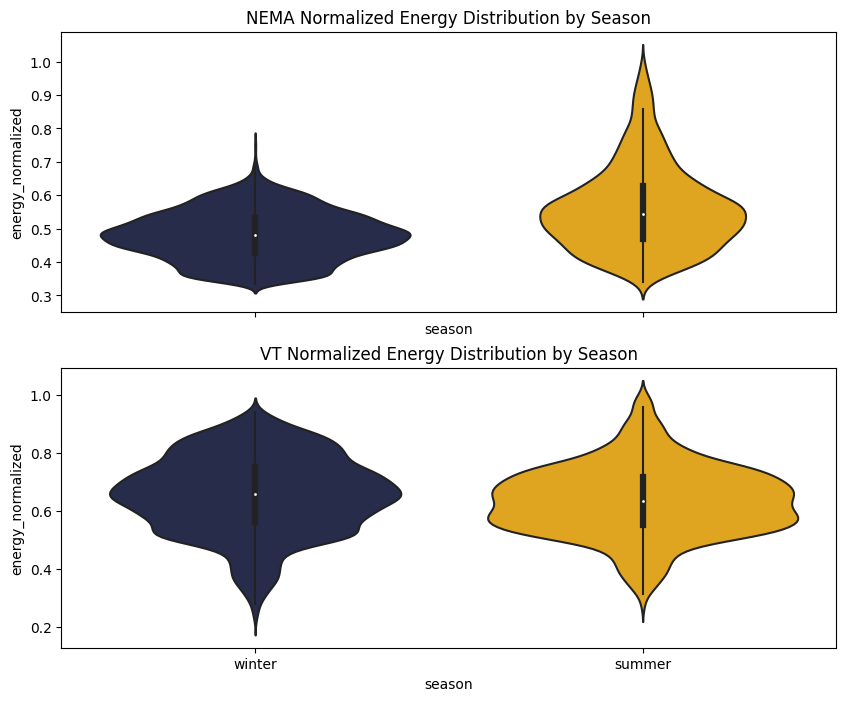

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),sharex=True)

custom_palette = {'summer': '#FFB100', 'winter': '#202850'}
# sns.set_palette(custom_palette)

sns.violinplot(x="season", y="energy_normalized", data=df_final[df_final.Location =='NEMA'],ax=ax1,palette=custom_palette)
ax1.set_title('NEMA Normalized Energy Distribution by Season')

sns.violinplot(x="season", y="energy_normalized", data=df_final[df_final.Location =='VT'],ax=ax2,palette=custom_palette)
ax2.set_title('VT Normalized Energy Distribution by Season');

In [20]:
df_final.head()

,datetime_hourly,Location,energy,lmp,loss,congestion,energyCost,t_f,day,month,...,energy_normalized,total_lmp,total_energyCost,total_loss,total_congestion,weighted_lmp,weighted_energyCost,weighted_loss,weighted_congestion,lmp_cost_pct
0,2021-01-01 00:00:00+00:00,VT,610.159,26.071667,-0.460000,0.0000,26.531667,25.1,2021-01-01,1,...,0.688643,15907.862062,16188.535202,-280.673140,0.00000,0.003171,0.003227,-0.000056,0.000000,0.000067
1,2021-01-01 01:00:00+00:00,VT,588.621,43.751667,-0.503333,0.0000,44.255000,26.0,2021-01-01,1,...,0.664335,25753.149785,26049.422355,-296.272570,0.00000,0.005133,0.005192,-0.000059,0.000000,0.000109
2,2021-01-01 02:00:00+00:00,VT,573.332,24.340000,-0.240000,0.0000,24.580000,26.1,2021-01-01,1,...,0.647079,13954.900880,14092.500560,-137.599680,0.00000,0.002781,0.002809,-0.000027,0.000000,0.000059
3,2021-01-01 03:00:00+00:00,VT,567.419,24.612500,-0.222500,0.0000,24.835000,27.1,2021-01-01,1,...,0.640405,13965.600137,14091.850865,-126.250727,0.00000,0.002783,0.002809,-0.000025,0.000000,0.000059
4,2021-01-01 04:00:00+00:00,VT,570.784,24.701667,-0.219167,0.0175,24.903333,28.0,2021-01-01,1,...,0.644203,14099.316107,14214.424213,-125.096827,9.98872,0.002810,0.002833,-0.000025,0.000002,0.000060


In [23]:
df_final['weighted_lmp_c'] = df_final.groupby(['Location'])['weighted_lmp'].cumsum()
df_final['weighted_loss_c'] = df_final.groupby(['Location'])['weighted_loss'].cumsum()
df_final['weighted_cong_c'] = df_final.groupby(['Location'])['weighted_congestion'].cumsum()
df_final['weighted_energyCost_c'] = df_final.groupby(['Location'])['weighted_energyCost'].cumsum()

In [24]:
df_final.groupby('Location').agg(weighted_lmp=('weighted_lmp','sum'))

,weighted_lmp
Location,
NEMA,47.805449
VT,46.999689


In [25]:
0.559594+0.051756+47.194099

47.805449

In [26]:
-0.491653+-0.048312+47.539654

46.999689

In [27]:
grouped_costs

,Location,weighted_loss,weighted_congestion,weighted_energyCost
0,NEMA,0.559594,0.051756,47.194099
1,VT,-0.491653,-0.048312,47.539654


In [28]:
grouped_costs = df_final[['Location','weighted_loss','weighted_congestion','weighted_energyCost']].groupby('Location',as_index=False).sum()

melted = pd.melt(grouped_costs, id_vars=['Location'], var_name='type', value_name='Value')



<Figure size 1500x500 with 0 Axes>

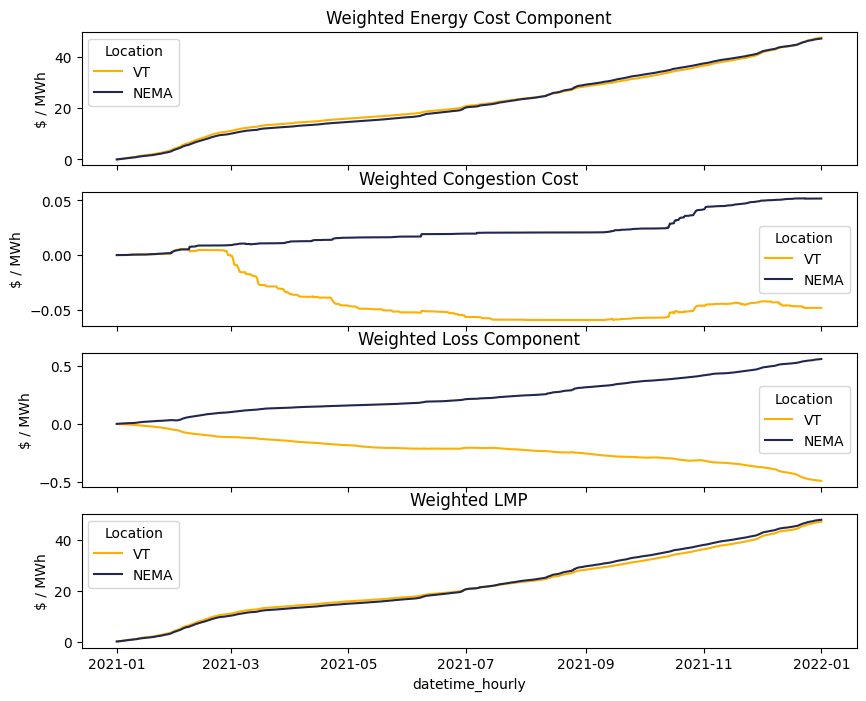

In [29]:
plt.figure(figsize=(15,5))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8),sharex=True)

custom_palette = {'VT': '#FEB000', 'NEMA': '#212850'}

sns.lineplot(data=df_final,x='datetime_hourly',y='weighted_lmp_c',hue='Location',ax=ax4,palette=custom_palette)
ax4.set_title('Weighted LMP')
ax4.set_ylabel('$ / MWh')

sns.lineplot(data=df_final,x='datetime_hourly',y='weighted_loss_c',hue='Location',ax=ax3,palette=custom_palette)
ax3.set_title('Weighted Loss Component')
ax3.set_ylabel('$ / MWh')

sns.lineplot(data=df_final,x='datetime_hourly',y='weighted_cong_c',hue='Location',ax=ax2,palette=custom_palette)
ax2.set_title('Weighted Congestion Cost')
ax2.set_ylabel('$ / MWh')

sns.lineplot(data=df_final,x='datetime_hourly',y='weighted_energyCost_c',hue='Location',ax=ax1,palette=custom_palette)
ax1.set_title('Weighted Energy Cost Component')
ax1.set_ylabel('$ / MWh');

In [30]:
def temp_regression(df,y_var):
    # split b/t area
    vt = df[(df.Location == 'VT') & (df[f'{y_var}'].notnull())]
    nema = df[(df.Location == 'NEMA') & (df[f'{y_var}'].notnull())]
    
    # HDD:
    vt_heating = vt[vt.t_f < 40]
    nema_heating = nema[nema.t_f < 40]
    
    # CDD:
    vt_cooling = vt[vt.t_f > 75]
    nema_cooling = nema[nema.t_f > 75]
    
    # Regr
    model = LinearRegression()

    # Fit the model to the data
    model.fit(vt_heating[['t_f']], vt_heating[f'{y_var}'])
    vt_h_coef = {'name':'VT_h','Intercept': model.intercept_, 'Coefficient': model.coef_[0]}
    
    # Fit the model to the data
    model.fit(nema_heating[['t_f']], nema_heating[f'{y_var}'])
    nema_h_coef = {'name':'NEMA_h','Intercept': model.intercept_, 'Coefficient': model.coef_[0]}
    
    # Fit the model to the data
    model.fit(vt_cooling[['t_f']], vt_cooling[f'{y_var}'])
    vt_c_coef = {'name':'VT_c','Intercept': model.intercept_, 'Coefficient': model.coef_[0]}
    
    # Fit the model to the data
    model.fit(nema_cooling[['t_f']], nema_cooling[f'{y_var}'])
    nema_c_coef = {'name':'NEMA_c','Intercept': model.intercept_, 'Coefficient': model.coef_[0]}
    
    return pd.DataFrame((vt_h_coef,nema_h_coef,vt_c_coef,nema_c_coef))
    

In [31]:
vt_ldc

0       1.000000
1       0.999124
2       0.999061
3       0.998649
4       0.997163
          ...   
8743    0.243023
8744    0.240954
8745    0.236694
8746    0.233578
8747    0.218480
Name: energy, Length: 8748, dtype: float64

In [36]:
pd.DataFrame(vt_ldc)

,energy
0,1.000000
1,0.999124
2,0.999061
3,0.998649
4,0.997163
...,...
8743,0.243023
8744,0.240954
8745,0.236694
8746,0.233578


In [32]:
test = temp_regression(df_final,'lmp')

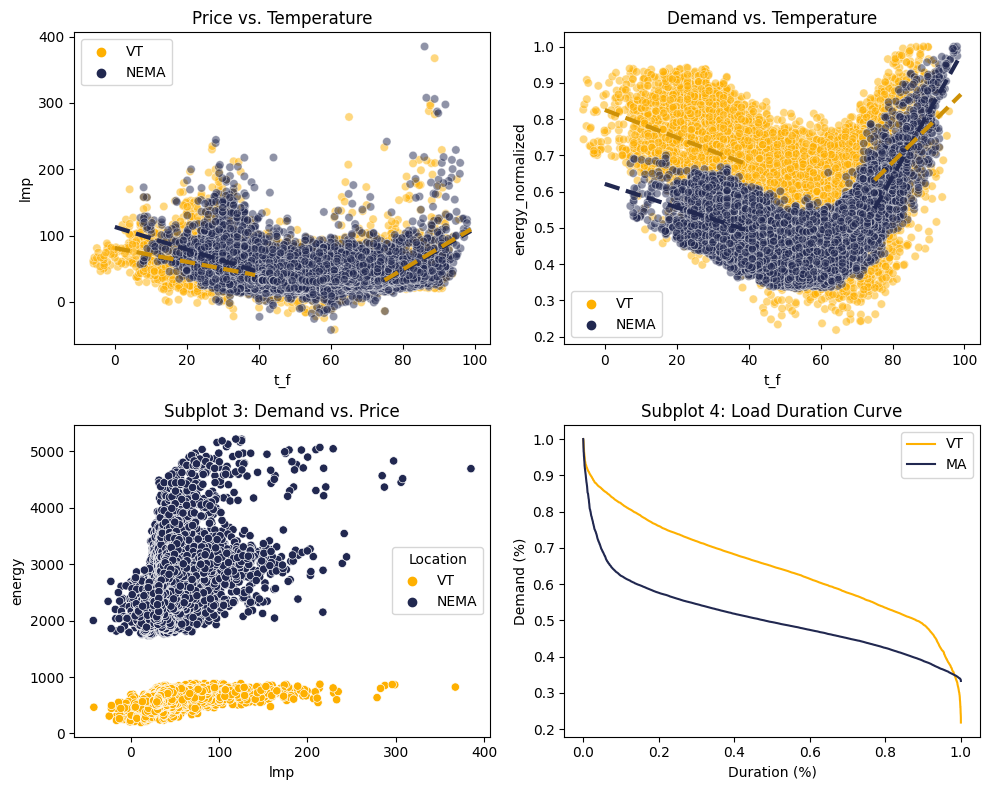

In [33]:
# LOAD DURATION CURVE
vt_ldc = df_final[(df_final.energy.notnull()) & (df_final.Location == 'VT')].sort_values('energy',ascending=False).energy.reset_index(drop=True)
ma_ldc = df_final[(df_final.energy.notnull()) & (df_final.Location == 'NEMA')].sort_values('energy',ascending=False).energy.reset_index(drop=True)

max_vt = max(vt_ldc)
max_ma = max(ma_ldc)

vt_ldc = vt_ldc / max_vt
ma_ldc = ma_ldc / max_ma

ldc_index_vt = np.linspace(0, 1, len(vt_ldc)) #np.arange(0,len(vt_ldc))
ldc_index_ma = np.linspace(0, 1, len(ma_ldc)) #np.arange(0,len(ma_ldc))

# REGR:
t_regr = temp_regression(df_final,'lmp')

cooling_x = np.arange(75,100,1)
heating_x = np.arange(0,40,1)

custom_palette = {'VT': '#FEB000', 'NEMA': '#212850'}

# Create a 2x2 grid of subplots and obtain axis handles
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# Plot data on each subplot using Seaborn
sns.scatterplot(data = df_final, x='t_f', y='lmp',hue='Location',alpha=.5, ax=ax1,palette=custom_palette)
sns.lineplot(x=cooling_x,y=cooling_x * t_regr.iloc[3,2] + t_regr.iloc[3,1],ax=ax1,color='#212850',linewidth=3,linestyle='dashed')
sns.lineplot(x=cooling_x,y=cooling_x * t_regr.iloc[2,2] + t_regr.iloc[2,1],ax=ax1,color='#ce9106ff',linewidth=3,linestyle='dashed')
sns.lineplot(x=heating_x,y=heating_x * t_regr.iloc[0,2] + t_regr.iloc[0,1],ax=ax1,color='#ce9106ff',linewidth=3,linestyle='dashed')
sns.lineplot(x=heating_x,y=heating_x * t_regr.iloc[1,2] + t_regr.iloc[1,1],ax=ax1,color='#212850',linewidth=3,linestyle='dashed')
ax1.set_title('Price vs. Temperature')

sns.scatterplot(data = df_final, x='t_f', y='energy_normalized',hue='Location',alpha=.5, ax=ax2,palette=custom_palette)
e_regr = temp_regression(df_final,'energy_normalized')
sns.lineplot(x=cooling_x,y=cooling_x * e_regr.iloc[3,2] + e_regr.iloc[3,1],ax=ax2,color='#212850',linewidth=3,linestyle='dashed')
sns.lineplot(x=cooling_x,y=cooling_x * e_regr.iloc[2,2] + e_regr.iloc[2,1],ax=ax2,color='#ce9106ff',linewidth=3,linestyle='dashed')
sns.lineplot(x=heating_x,y=heating_x * e_regr.iloc[0,2] + e_regr.iloc[0,1],ax=ax2,color='#ce9106ff',linewidth=3,linestyle='dashed')
sns.lineplot(x=heating_x,y=heating_x * e_regr.iloc[1,2] + e_regr.iloc[1,1],ax=ax2,color='#212850',linewidth=3,linestyle='dashed')
ax2.set_title('Demand vs. Temperature')

sns.scatterplot(data = df_final, x='lmp', y='energy',hue='Location',ax=ax3,palette=custom_palette)
ax3.set_title('Subplot 3: Demand vs. Price')

# sns.lineplot(data = vt_ldc, x='Index', y='Load',color='Blue', ax=ax4)
sns.lineplot(x=ldc_index_vt,y=vt_ldc,label='VT',ax=ax4,color = '#FEB000')
sns.lineplot(x=ldc_index_ma,y=ma_ldc,label='MA',ax=ax4,color = '#212850')
ax4.legend()
ax4.set_xlabel('Duration (%)')
ax4.set_ylabel('Demand (%)');
ax4.set_title('Subplot 4: Load Duration Curve')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [34]:
df_final.head(2)

,datetime_hourly,Location,energy,lmp,loss,congestion,energyCost,t_f,day,month,...,total_congestion,weighted_lmp,weighted_energyCost,weighted_loss,weighted_congestion,lmp_cost_pct,weighted_lmp_c,weighted_loss_c,weighted_cong_c,weighted_energyCost_c
0,2021-01-01 00:00:00+00:00,VT,610.159,26.071667,-0.460000,0.0,26.531667,25.1,2021-01-01,1,...,0.0,0.003171,0.003227,-0.000056,0.0,0.000067,0.003171,-0.000056,0.0,0.003227
1,2021-01-01 01:00:00+00:00,VT,588.621,43.751667,-0.503333,0.0,44.255000,26.0,2021-01-01,1,...,0.0,0.005133,0.005192,-0.000059,0.0,0.000109,0.008303,-0.000115,0.0,0.008418


In [74]:
# MAX BY MONTH
md_season = df_final.groupby(['Location','season'],as_index=False).agg(energy = ('energy','max'))

In [75]:
md_season

,Location,season,energy
0,NEMA,summer,5220.137
1,NEMA,winter,3972.070
2,VT,summer,886.031
3,VT,winter,834.441


In [146]:
top_n = 5
max_index = df_final.groupby(['Location','season'])['energy'].idxmax()#indexid#.nlargest(top_n).index
result_df = df_final.iloc[max_index][['Location','day']].reset_index(drop=True)
top_season_peaks = result_df.merge(df_final)

# Use groupby and nlargest to get indices of the top N values within each group
# top_indices = df.groupby('Group')['Value'].nlargest(top_n).index.get_level_values(1)

/anaconda3/envs/powersupply/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


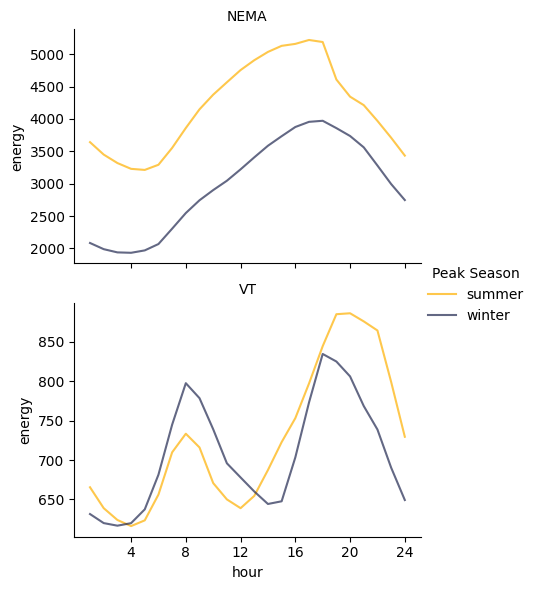

In [380]:
# sns.lineplot(data=top_season_peaks,x='hour',y='energy',hue='season')
height = 4
subplot_width = 6

aspect = subplot_width / height

custom_palette = {'summer': '#FEB000', 'winter': '#212850'}

grid = sns.FacetGrid(top_season_peaks, col="Location", hue="season",col_wrap=1, height=3,aspect=aspect,sharey=False,legend_out=True,
                    palette=custom_palette)

# Map a plot type (e.g., scatter plot) to the grid
grid.map(sns.lineplot, "hour", "energy", alpha=0.7)

grid.add_legend(title="Peak Season")

# Add a title for each subplot
grid.set_titles("{col_name}")

# grid.set(xlim=(1, 24))
x_ticks = [4, 8, 12, 16, 20, 24]  # Adjust based on your requirements
grid.set(xticks=x_ticks)

# Show the plot
plt.show();

In [97]:
df_final[df_final.day == pd.to_datetime('2021e-08-26')]

,datetime_hourly,Location,energy,lmp,t_f,day,month,hour,season


In [98]:
df_final.dtypes

datetime_hourly    datetime64[ns, UTC]
Location                        object
energy                         float64
lmp                            float64
t_f                            float64
day                             object
month                            int32
hour                             int32
season                          object
dtype: object